In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_disparity_dynamic(Il, Ir, sigma=2, c0=1):
    """Compute disparity map using dynamic programming.

    Args:
        Il: Left image (grayscale, 2D numpy array).
        Ir: Right image (grayscale, 2D numpy array).
        sigma: Pixel noise standard deviation.
        c0: Occlusion cost.

    Returns:
        Disparity map as 2D numpy array (float32).
    """
    h, w = Il.shape
    disparity_map = np.zeros((h, w), dtype=np.float32)

    for row in range(h):
        left_row = Il[row, :]
        right_row = Ir[row, :]
        n = len(left_row)

        # Initialize cost matrix D
        D = np.zeros((n + 1, n + 1), dtype=np.float32)
        D[0, :] = np.arange(n + 1) * c0
        D[:, 0] = np.arange(n + 1) * c0

        # Fill D using recurrence relation
        for i in range(1, n + 1):
            for j in range(1, n + 1):
                diff = (np.int32(left_row[i - 1]) - np.int32(right_row[j - 1]))
                dij = (diff ** 2) / (sigma ** 2)
                D[i, j] = min(
                    D[i - 1, j - 1] + dij,  # Match
                    D[i - 1, j] + c0,       # Skip left
                    D[i, j - 1] + c0        # Skip right
                )

        # Backtracking to find disparities
        i, j = n, n
        disp_row = np.zeros(n, dtype=np.float32)

        while i > 0 and j > 0:
            diff = (np.int32(left_row[i - 1]) - np.int32(right_row[j - 1]))
            cost = (diff ** 2) / (sigma ** 2)
            if np.isclose(D[i, j], D[i - 1, j - 1] + cost):
                disp_row[i - 1] = abs(i - j)
                i -= 1
                j -= 1
            elif np.isclose(D[i, j], D[i - 1, j] + c0):
                disp_row[i - 1] = 0  # skip left
                i -= 1
            else:
                j -= 1  # skip right

        # Handle remaining unmatched left pixels
        while i > 0:
            disp_row[i - 1] = 0
            i -= 1

        disparity_map[row, :] = disp_row

    return disparity_map


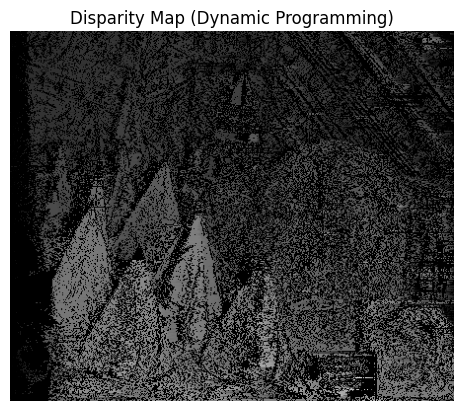

In [3]:

# Load stereo images
imgl = cv2.imread('stereo_materials/l2.png', cv2.IMREAD_GRAYSCALE)
imgr = cv2.imread('stereo_materials/r2.png', cv2.IMREAD_GRAYSCALE)

# Compute disparity map using dynamic programming
disparity_dp = compute_disparity_dynamic(imgl, imgr, sigma=2, c0=1)

# Normalize and show/save
disp_display = cv2.normalize(disparity_dp, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disp_display = np.uint8(disp_display)

plt.imshow(disp_display, cmap='gray')
plt.title('Disparity Map (Dynamic Programming)')
plt.axis('off')
plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_alignment_path(Il_row, Ir_row, sigma=2, c0=1):
    """Plot alignment path between two 1D scanlines using dynamic programming."""
    n = len(Il_row)
    D = np.zeros((n + 1, n + 1), dtype=np.float32)
    D[0, :] = np.arange(n + 1) * c0
    D[:, 0] = np.arange(n + 1) * c0

    # Fill DP matrix
    for i in range(1, n + 1):
        for j in range(1, n + 1):
            diff = (np.int32(Il_row[i - 1]) - np.int32(Ir_row[j - 1]))
            dij = (diff ** 2) / (sigma ** 2)
            D[i, j] = min(
                D[i - 1, j - 1] + dij,
                D[i - 1, j] + c0,
                D[i, j - 1] + c0
            )

    # Backtrack to find the alignment path
    i, j = n, n
    path = []

    while i > 0 and j > 0:
        diff = (np.int32(Il_row[i - 1]) - np.int32(Ir_row[j - 1]))
        cost = (diff ** 2) / (sigma ** 2)
        if np.isclose(D[i, j], D[i - 1, j - 1] + cost):
            path.append(((i - 1), (j - 1), 'match'))
            i -= 1
            j -= 1
        elif np.isclose(D[i, j], D[i - 1, j] + c0):
            path.append(((i - 1), j, 'skip_left'))
            i -= 1
        else:
            path.append((i, (j - 1), 'skip_right'))
            j -= 1

    while i > 0:
        path.append(((i - 1), 0, 'skip_left'))
        i -= 1
    while j > 0:
        path.append((0, (j - 1), 'skip_right'))
        j -= 1

    path.reverse()

    # Plot alignment
    plt.figure(figsize=(8, 8))
    for (i, j, action) in path:
        if action == 'match':
            plt.plot(j, i, 'o', color='green')
            plt.plot([j], [i], 'o', color='green')
        elif action == 'skip_left':
            plt.plot(j, i, 'v', color='blue')  # Down arrow
        elif action == 'skip_right':
            plt.plot(j, i, '<', color='red')   # Left arrow

    plt.xlabel('Right Image Pixels (Ir)')
    plt.ylabel('Left Image Pixels (Il)')
    plt.title('Alignment Path')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()


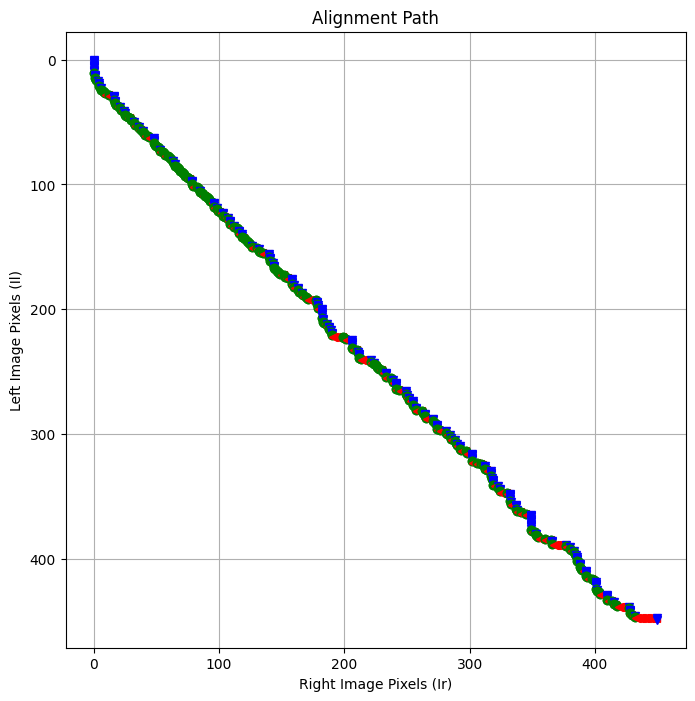

In [5]:
row_index = 50
plot_alignment_path(imgl[row_index, :], imgr[row_index, :])
